In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Conv2DTranspose,UpSampling2D
from tensorflow.keras.models import Model
import numpy as np

In [2]:
pip install segmentation_models

Note: you may need to restart the kernel to use updated packages.


In [3]:
from segmentation_models.losses import bce_jaccard_loss,dice_loss
from segmentation_models.metrics import iou_score,f1_score

Segmentation Models: using `keras` framework.


In [4]:
data_gen=ImageDataGenerator(rescale=1/255,data_format='channels_last')
mask_gen=ImageDataGenerator(data_format='channels_last')

In [5]:
train=data_gen.flow_from_directory('/kaggle/input/adjusted-updated-cloths-data/New_Image_Mask_data',
                                  target_size=(320,160),
                                   shuffle=False,
                                  classes=['images'])
mask=data_gen.flow_from_directory('/kaggle/input/adjusted-updated-cloths-data/New_Image_Mask_data',
                                  target_size=(320,160),
                                  shuffle=False,
                                  classes=['masks'])
path=pd.DataFrame()
path['train']=train.filepaths
path['mask']=mask.filepaths
from sklearn.model_selection import train_test_split
path,valid=train_test_split(path,test_size=0.1)
train1=data_gen.flow_from_dataframe(path,x_col='train',
                                    target_size=(256,256),
                                    class_mode=None,
                                    shuffle=False,
                                   batch_size=16)
mask1=mask_gen.flow_from_dataframe(path,x_col='mask',
                                   target_size=(256,256),
                                   class_mode=None,
                                   shuffle=False,
                                  batch_size=16,
                                   classes=None,
                                  color_mode='grayscale')

v_train1=data_gen.flow_from_dataframe(valid,x_col='train',
                                    target_size=(256,256),
                                    class_mode=None,
                                    shuffle=False,
                                   batch_size=16)
v_mask1=mask_gen.flow_from_dataframe(valid,x_col='mask',
                                   target_size=(256,256),
                                   class_mode=None,
                                   shuffle=False,
                                  batch_size=16,
                                   classes=None,
                                  color_mode='grayscale')

Found 13752 images belonging to 1 classes.
Found 13752 images belonging to 1 classes.
Found 12376 validated image filenames.
Found 12376 validated image filenames.
Found 1376 validated image filenames.
Found 1376 validated image filenames.


In [6]:
train1[0].shape

(16, 256, 256, 3)

(256, 256, 1)

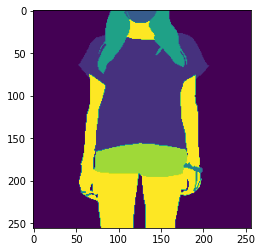

In [7]:
plt.imshow(mask1[0][0])
mask1[0][0].shape

In [8]:
np.unique(mask1[0][0])

array([0., 1., 2., 3., 4., 6., 7.], dtype=float32)

from sklearn.model_selection import train_test_split
train1,mask1,train_v,mask_v=train_test_split(train1,mask1,test_size=0.2,random_state=42)

In [9]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same",data_format='channels_last')(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same",data_format='channels_last')(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2),data_format='channels_last')(x)
    return x, p   
#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same",data_format='channels_last')(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation,data_format='channels_last')(d4)  #Change the activation based on n_classes
    print(activation)
    model = Model(inputs, outputs, name="U-Net")
    return model

In [10]:
input_shape = (256,256,3)

In [11]:
strategy = tf.distribute.MirroredStrategy()
batch_size = 16 * strategy.num_replicas_in_sync
with strategy.scope():
    model = build_unet(input_shape, n_classes=8)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy',iou_score,f1_score])
    model.summary()

2022-12-09 07:21:44.071408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 07:21:44.072304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 07:21:44.080847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 07:21:44.081697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 07:21:44.082429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

softmax
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [12]:
callback=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=1)
history = model.fit(zip(train1,mask1), 
                    validation_data=zip(v_train1,v_mask1),
                    validation_batch_size=16,
                    validation_steps=86,
                    batch_size = batch_size, 
                    verbose=1, 
                    epochs=2,
                    shuffle=False,
                   steps_per_epoch=774,
                   callbacks=[callback])

2022-12-09 07:22:38.855173: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_3011"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key

Epoch 1/2


2022-12-09 07:22:53.070631: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-12-09 07:22:54.051672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


774/774 [==============================] - ETA: 0s - loss: 0.3231 - accuracy: 0.5970 - iou_score: 0.1611 - f1-score: 0.2334

2022-12-09 07:30:26.209098: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_22029"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  ke

774/774 [==============================] - 501s 615ms/step - loss: 0.3231 - accuracy: 0.5970 - iou_score: 0.1611 - f1-score: 0.2334 - val_loss: 0.3082 - val_accuracy: 0.5794 - val_iou_score: 0.1591 - val_f1-score: 0.2336
Epoch 2/2
774/774 [==============================] - 473s 611ms/step - loss: 0.2020 - accuracy: 0.5962 - iou_score: 0.1674 - f1-score: 0.2343 - val_loss: 0.2460 - val_accuracy: 0.5908 - val_iou_score: 0.1715 - val_f1-score: 0.2327


In [13]:
x=model.predict(train1[1],verbose=1)

2022-12-09 07:38:52.726896: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_27785"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

1/1 [==============================] - 2s 2s/step


In [14]:
pred_mask = tf.math.argmax(model.predict(train1[1]), axis=-1)

2022-12-09 07:38:55.405535: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_29170"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

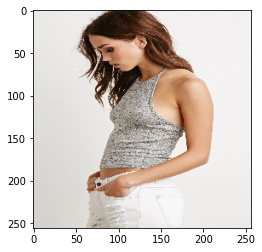

In [15]:
plt.imshow(train1[1][0])

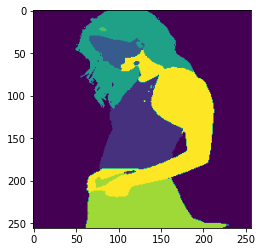

In [16]:
plt.imshow(pred_mask[0])

In [17]:
print(tf.test.gpu_device_name())

/device:GPU:0


2022-12-09 07:39:08.851729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 07:39:08.852365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 07:39:08.852874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 07:39:08.853275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 07:39:08.853724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [18]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
tf.keras.models.save_model(model,'Updated_final.h5')